## DML para Painel com Heterogeneidade Não Observada

### Double Machine Learning - Correlated Random Effects (DML-CRE)

Prof. Daniel de Abreu Pereira Uhr

### Conteúdo

* Introdução
* Por que “demeanar e rodar DML” é perigoso?
* O que é o DML + CRE (Mundlak) que eles recomendam?
* O que os autores encontram nas simulações?
* Recomendações formais
* Um “esqueleto” de DML em painel 
* Resumo


### Referência

* Jonathan Fuhr and Dominik Papies (2024). Double Machine Learning meets Panel Data - Promises, Pitfalls, and Potential Solutions. https://arxiv.org/abs/2409.01266


**Observações:** O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer *feedback* ou sugestão de melhoria.

---

#### Introdução

O artigo parte do DML “padrão” (Chernozhukov et al., 2018), que é pensado para **amostra i.i.d. cross-sectional**, e pergunta:

> “Como adaptar DML para **painel** quando há heterogeneidade não observada (U_i) que afeta tanto (Y_{it}) quanto (X_{it})?”

Eles consideram um modelo do tipo:

$$
Y_{it} = \theta_0 D_{it} + g_0(X_{it}, U_i) + \varepsilon_{it}
$$

* $Y_{it}$ – outcome de interesse 
* $D_{it}$ – tratamento cujo efeito causal (\theta_0) queremos identificar.
* $X_{it}$ – vetor de confounders observados 
* $U_i$ – heterogeneidade **não observada**, fixa no tempo (características intrínsecas do nível individual $i$)
* E a chave: **eles admitem explicitamente o caminho (U_i \to X_{it})**, i.e., $U_i$ influencia também os confounders observados. 

Esse caminho $U_i \to X_{it}$ é o que mata a complacência: não é só FE linear clássico; com confusão não linear, “aplicar FE e depois DML” deixa de ser uma solução simples.


#### Por que “demeanar e rodar DML” é perigoso?

A nossa tentação natural é:

1. Fazer **within transform** (***demeaning por unidade***) em ($Y$), ($D$), ($X$);
2. Rodar DML nos dados transformados, análogo ao FE.

O artigo mostra, via simulações, que:

* DML em variáveis time-demeaned, à la FE, é **fortemente enviesado** quando a relação de confusão é não linear, justamente porque nesse caso o “efeito fixo aditivo” não separa bem $U_i$ de $X_{it}$. 
* Vários esquemas intuitivos que tentam “tirar” $U_i$ primeiro e depois aplicar DML falham quando há não linearidade e/ou $U_i \to X_{it}$. 

Moral: **não** seguir aquele impulso de:

> “Vou transformar tudo em desvio da média individual e pronto.”

Econometricamente, o que a simulação mostra é:

* O FE clássico funciona num mundo **paramétrico linear** com $U_i$ aditivo;
* Quando você substitui essa fase de “ajustar por $X_{it}$” por um ML flexível dentro de DML, a estrutura additiva em $U_i$ pode não segurar, e o demeaning “bagunça” a identificação do efeito de interesse.


#### O que é o DML + CRE (Mundlak) que eles recomendam?

A solução que funciona bem nos experimentos deles é usar DML com uma adaptação **à la Mundlak (1978)**:

***Idéia de CRE/Mundlak***

Em painel linear tradicional, o método de **Correlated Random Effects (CRE)** diz:

* Em vez de assumir $U_i$ independente de $X_{it}$, modelar:

$$
U_i = \alpha + \bar{X}_i'\delta + a_i,
$$

onde $\bar{X}_i$ são as **médias no tempo** das covariáveis de cada unidade (Mundlak).

* Inserindo $\bar{X}*i$ como regressoras, você “limpa” a correlação entre $X*{it}$ e $U_i$; o resto $a_i$ vira efeito aleatório “puro”.

O artigo leva essa ideia para dentro do DML:

> **Adicionar as médias por unidade $\bar{X}_i$ como covariáveis extras nos modelos de previsão usados em DML**, tanto no modelo de outcome quanto no de tratamento/propensity. 

Ou seja, em vez de de-mean, você **enriquece $X_{it}$**:

$$
X_{it}^{\text{aug}} = \big(X_{it}, \bar{X}_i\big).
$$



### O que os autores encontram nas simulações?

* DML em de-meaned data (tipo FE) → **grande viés** quando o confounding é não linear. 
* DML com CRE/Mundlak (isto é, incluindo médias de $X_{it}$ nos modelos ML) → funciona bem em vários cenários, desde que:

  * **amostra grande** em relação ao número de covariáveis (porque você está duplicando o número de features).
* Variações da forma de cross-fitting (aleatória, por tempo, por bloco) afetam pouco o viés/consistência, comparado com o problema da heterogeneidade não observada; o grande “ganho” vem de modelar $U_i$ via Mundlak. 

### Recomendações formais

Eles explicitam quatro recomendações finais: 

1. **Sempre comparar FE tradicional com DML+CRE**

   * Em aplicações onde hoje você usa FE, rode também DML com CRE (Mundlak) e compare os coeficientes. Diferenças grandes sugerem problemas de especificação funcional no modelo linear FE.

2. **Confiar mais no DML quando $N$ é grande e $p$ é pequeno**

   * Ganho de DML é maior se você tem muitas observações e um conjunto não tão gigantesco de confounders observados.

3. **Não fazer cross-fitting “por unidade” se seu objetivo é modelar $U_i$**

   * Dentro do algoritmo DML, quando você faz as predições ML dos termos de confusão, **não separe as unidades em folds distintos** (i.e., não usar GroupKFold por unidade no cross-fitting), porque isso impede o ML de ver a relação entre $\bar{X}*i$ e $X*{it}$ ao longo do tempo para aquele mesmo $i$. 
   * Ou seja: **cross-fitting por observação, não por unidade**.

4. **Não levar a sério os erros-padrão desses DML em painel**

   * Ainda não há teoria clara para variâncias quando há **dependência em cluster (unidade) + tempo** + cross-fitting.
   * Moral: usar esses DML em painel principalmente como **estimadores pontuais / checks de robustez**, não para inference “bonitinha” com IC 95% “oficial”. 


### Um “esqueleto” de DML em painel 

1. **Definir o objeto causal**

   * Ex.: efeito médio de $D$ sobre a $Y$

2. **Construir $X_{it}$ e $\bar{X}_i$**

   * features $X$ + suas médias por unidade $i$.

3. **Rodar DML parcialmente linear** (tipo `LinearDML` ou `DML` customizado):

   * Outcome model: $Y_{it} \sim f(X_{it}, \bar{X}_i)$ via ML.
   * Treatment model: $D_{it} \sim g(X_{it}, \bar{X}_i)$ via ML.
   * Cross-fitting: KFold ou blocos de tempo **sem separar por município**.
   * Estimador final: regressão da pseudo-outcome na pseudo-treatment (score Neyman-ortogonal), como no DML padrão.

4. **Comparar esse $\hat{\theta}_{DML+CRE}$ com o FE tradicional**

   * FE linear clássico (demeaning) como benchmark.
   * Diferenças grandes → suspeita de misspecificação funcional na FE.

5. **Usar os erros-padrão com parcimônia**

   * Conforme recomendação (4): não vender os IC como “gold standard”, por limitação teórica ainda aberta.


### Resumo

  * Não aplicar FE/demeaning antes de ML;
  * Construir Mundlak (médias por município) para todas as covariáveis relevantes e incluí-las nos modelos;
  * Quando quiser fazer DML causal, fazer cross-fitting por observações (ou blocos de tempo), não por unidade;
  * Tratar os DML como estimadores pontuais robustos e usar FE como benchmark, sem confiar cegamente em SEs.

### Aplicação em Python


Vamos aplicar o DML aos dados em painel, incluindo as médias por unidade (Mundlak) como features adicionais.

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

data = pd.read_stata("https://github.com/Daniel-Uhr/data/raw/main/bacon_example.dta")

In [90]:
# Outcome (Suicide Mortality)
data['Y'] = data['asmrs']
# Treatment D (Staggered treatment adoption)
data['D'] = data['post']
# Covariáveis - pcinc asmrh cases
data['X1'] = data['pcinc']
data['X2'] = data['asmrh']
data['X3'] = data['cases']

# Identificação do painel
data['year'] = data['year'].astype(int)
data['id'] = data['stfips'].astype('category').cat.codes + 1


# Relative time (Tempo relativo até o tratamento - ocorre somente para os tratados)
data['reltime'] = data['year'] - data['_nfd']
# colocar valor zero caso tenha dados faltantes
data['reltime'] = data['reltime'].fillna(0)
# garantir que 'reltime' seja um inteiro
data['reltime'] = data['reltime'].astype(int)

# Generates a new column called 'ct' containing the numerics version of calendar time 'year'
data['ct'] = data['year'] - 1964

# Vamos criar a variável de grupo (cohoort) e G (Callaway-SantAnna)
data['cohort'] = data['_nfd'] - 1965
data['G']=data['_nfd']

# control group
data['treated'] = 0
data.loc[data['_nfd'] > 0, 'treated'] = 1
data['untreated_group'] = 1
data.loc[data['treated'] == 1, 'untreated_group'] = 0

# Criar uma coluna que identifica os indivíduos que nunca foram tratados (nevertreated)
data['nevertreated'] = 0
data.loc[data['treated'] == 0, 'nevertreated'] = 1

# Criar uma coluna que identifica os indivíduos que sempre foram tratados (alwaystreated) Deve ser 1 para todos os anos após o tratamento D
data['mean_treat'] = data.groupby('id')['D'].transform('mean')
# Criar os sempre tratados
data['alwaystreated'] = 0
data.loc[(data['mean_treat'] == 1), 'alwaystreated'] = 1

In [95]:
# Médias no tempo por unidade (Mundlak)
group_means = data.groupby('id')[['D', 'X1', 'X2', 'X3', 'year']].transform('mean')
group_means.columns = ['D_bar', 'X1_bar', 'X2_bar', 'X3_bar', 'year_bar']

data_cre = pd.concat([data, group_means], axis=1)


# Matriz de features para o DML (níveis + médias)
year_dummies = pd.get_dummies(data_cre['year'], prefix='year', drop_first=True)
X_cre = pd.concat(
    [data_cre[['X1','X2','X3','X1_bar','X2_bar','X3_bar','D_bar']], year_dummies],
    axis=1
)
Y = data_cre['Y'].values
T = data_cre['D'].values

In [256]:
from xgboost import XGBRegressor, XGBClassifier
from econml.dml import LinearDML
import numpy as np

# Modelo para Y|X (regressão)
base_learner_y = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",   # geralmente mais rápido
    n_jobs=-1,
    random_state=42
)

# Modelo para T|X (classificação, pois T é binário)
base_learner_t = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

dml_cre_xgb = LinearDML(
    model_y=base_learner_y,
    model_t=base_learner_t,
    discrete_treatment=True,   # importante para usar predict_proba no modelo T
    cv=3,
    random_state=42
)

dml_cre_xgb.fit(
    Y, T,
    X=X_cre.values,
    W=None
)

ate_cre_xgb = dml_cre_xgb.ate(X=X_cre.values)
print("ATE (XGBoost CRE):", ate_cre_xgb)

cate_cre_xgb = dml_cre_xgb.effect(X_cre.values)
print("média dos CATEs:", np.mean(cate_cre_xgb))


c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\econml-env\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:11:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\econml-env\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:11:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\danie\OneDrive\00000 - 2025\0_Python_Estimators\econml-env\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:11:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ATE (XGBoost CRE): -8.37255201465184
média dos CATEs: -8.37255201465184


***Event Study***

In [257]:
import numpy as np
import pandas as pd

# =========================
# 1) Event study via DML-CRE
# =========================

# janela de períodos (igual ao seu TWFE)
ks = sorted(data_cre['reltime'].unique())
ks = [k for k in ks if k != 0]   # remove baseline (0 é o período omitido aqui)

results = []

# CATEs para toda a amostra (mais eficiente)
cate_all = dml_cre_xgb.effect(X_cre.values)

for k in ks:
    # índice das observações naquele reltime
    mask_k = (data_cre['reltime'].to_numpy() == k)
    idx_k = np.where(mask_k)[0]

    # CATE no subconjunto: tau(k)
    cate_k = cate_all[idx_k]
    tau_k = np.mean(cate_k)

    # bootstrap para IC
    boot = []
    B = 1000
    for _ in range(B):
        idx_boot = np.random.choice(idx_k, size=len(idx_k), replace=True)
        boot.append(np.mean(cate_all[idx_boot]))

    lower = np.percentile(boot, 2.5)
    upper = np.percentile(boot, 97.5)

    results.append([k, tau_k, lower, upper])

# Montar tabela final
est_dml = pd.DataFrame(results, columns=['reltime', 'coef', 'lower', 'upper'])
est_dml = est_dml.sort_values('reltime').reset_index(drop=True)


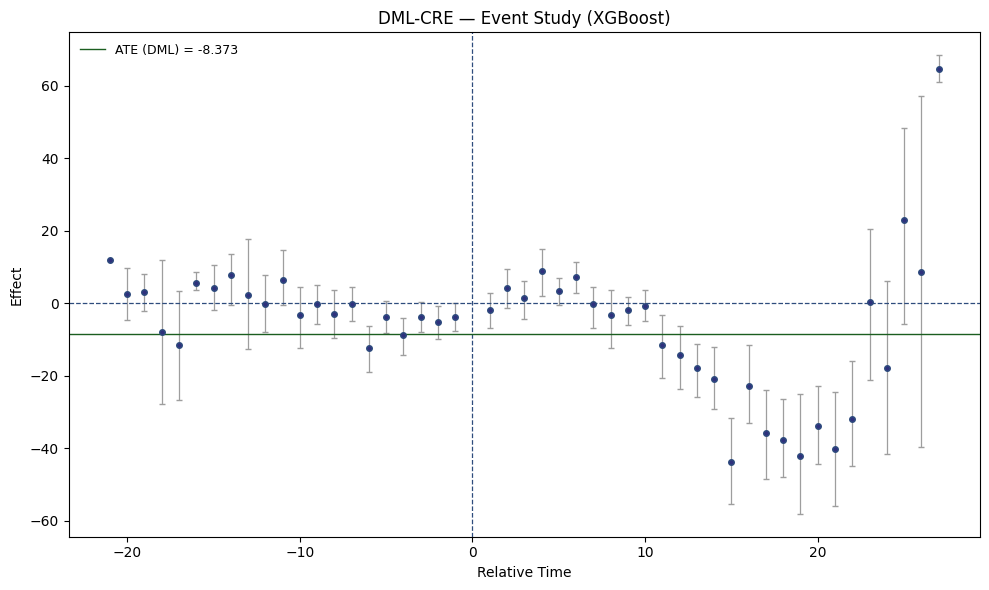

In [258]:
import matplotlib.pyplot as plt

# =========================
# 2) Gráfico (pontos + IC)
# =========================
x = est_dml["reltime"].to_numpy()
y = est_dml["coef"].to_numpy()
yerr = np.vstack([
    y - est_dml["lower"].to_numpy(),
    est_dml["upper"].to_numpy() - y
])

plt.figure(figsize=(10, 6))
plt.errorbar(
    x, y, yerr=yerr,
    fmt='o', markersize=4,
    markerfacecolor="#2E317D", markeredgecolor="#2E4C7D",
    ecolor="#9E9E9E", elinewidth=0.9, capsize=2
)

# Linha em zero (efeito nulo)
plt.axhline(0, linestyle='--', linewidth=0.9, color='#2E4C7D')

# Linha vertical no período de referência
# Se o período omitido for 0 (como no seu loop), use 0:
plt.axvline(0, linestyle='--', linewidth=0.9, color='#2E4C7D')
# Se você passar a omitir o -1 (como no CS), troque para:
# plt.axvline(-1, linestyle='--', linewidth=0.9, color='#2E4C7D')

# Linha do ATT médio (DML)
try:
    att_val = float(dml_cre_xgb.ate(X=X_cre.values))
    plt.axhline(att_val, color="#1B5E20", linestyle="-", linewidth=1.0,
                label=f"ATE (DML) = {att_val:.3f}")
    plt.legend(frameon=False, fontsize=9)
except Exception:
    pass

plt.title("DML-CRE — Event Study (XGBoost)", fontsize=12)
plt.xlabel("Relative Time", fontsize=10)
plt.ylabel("Effect", fontsize=10)
plt.tight_layout()
plt.show()
